In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import statsmodels.api as sm

In [56]:
font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)
print(len(강서_데이터))
일별_강서_데이터= 강서_데이터.groupby('기준_날짜')['전체_건수'].sum()

# Series를 DataFrame으로 변환
일별_강서_데이터 = pd.DataFrame(일별_강서_데이터.items(), columns=['기준_날짜', '전체_건수'])


3385613


In [57]:
기상청_데이터 = pd. read_csv('../../Data/기상청/기온강수량미세먼지2.csv',encoding='utf-8')
# 강수량 0인부분 채우기
기상청_데이터.fillna(0, inplace=True)
기상청_데이터.rename(columns={'일시': '기준_날짜'}, inplace=True)
기상청_데이터

,기준_날짜,미세먼지,초미세먼지,지점,지점명,평균기온(°C),일강수량(mm)
0,2023-04-01,111,56,108,서울,17.5,0.0
1,2023-04-02,60,32,108,서울,18.8,0.0
2,2023-04-03,58,32,108,서울,19.0,0.0
3,2023-04-04,38,18,108,서울,17.6,6.9
4,2023-04-05,20,10,108,서울,11.9,50.3
...,...,...,...,...,...,...,...
392,2024-03-27,24,15,108,서울,10.4,0.0
393,2024-03-28,25,11,108,서울,10.3,1.9
394,2024-03-29,277,43,108,서울,7.6,1.4
395,2024-03-30,104,23,108,서울,8.8,0.0


In [60]:

# 휴일 데이터
휴일 = [
    {"날짜": "2023-05-05"},
    {"날짜": "2023-05-29"},
    {"날짜": "2023-06-06"},
    {"날짜": "2023-08-15"},
    {"날짜": "2023-09-28"},
    {"날짜": "2023-09-29"},
    {"날짜": "2023-10-02"},
    {"날짜": "2023-10-03"},
    {"날짜": "2023-10-09"},
    {"날짜": "2023-12-25"},
    {"날짜": "2024-01-01"},
    {"날짜": "2024-02-09"},
    {"날짜": "2024-02-12"},
    {"날짜": "2024-03-01"},
]
# 주말과 휴일을 분류하는 함수 정의
def classify_weekend_and_holidays(df, holidays):
    # '일시' 열을 datetime 형식으로 변환
    df['기준_날짜'] = pd.to_datetime(df['기준_날짜'])
    
    # 주말(토요일: 5, 일요일: 6)인지 여부를 나타내는 열 추가
    df['요일'] = df['기준_날짜'].dt.dayofweek  # 0: 월요일, 1: 화요일, ..., 6: 일요일
    df['주말'] = df['요일'].apply(lambda x: 1 if x >= 5 else 0)  # 토요일(5) 또는 일요일(6)이면 주말로 분류
    
    # 휴일인지 여부를 나타내는 열 추가
    df['휴일'] = df['기준_날짜'].apply(lambda x: 1 if str(x.date()) in [h['날짜'] for h in holidays] else 0)
    
    # 주말과 휴일으로 데이터 분리
    주말_df = df[(df['주말'] == 1) | (df['휴일'] == 1)]
    주중_df = df[(df['주말'] == 0) & (df['휴일'] == 0)]
    
    return 주말_df, 주중_df

# 함수 호출
일별_휴일_데이터, 일별_강서_데이터 = classify_weekend_and_holidays(일별_강서_데이터, 휴일)

기상청_주말_데이터, 기상청_주중_데이터 = classify_weekend_and_holidays(기상청_데이터, 휴일)



In [61]:
일별_강서_데이터

,기준_날짜,전체_건수,요일,주말,휴일
0,2023-04-03,16354,0,0,0
1,2023-04-04,13309,1,0,0
2,2023-04-05,2191,2,0,0
3,2023-04-06,7303,3,0,0
4,2023-04-07,14320,4,0,0
...,...,...,...,...,...
236,2024-03-25,6757,0,0,0
237,2024-03-26,9299,1,0,0
238,2024-03-27,15206,2,0,0
239,2024-03-28,9280,3,0,0


In [62]:
# 기상청_주중_데이터의 '기준_날짜' 열을 datetime 형식으로 변환
기상청_주중_데이터['기준_날짜'] = pd.to_datetime(기상청_주중_데이터['기준_날짜'])

# 일별_강서_데이터의 '기준_날짜' 열을 datetime 형식으로 변환
일별_강서_데이터['기준_날짜'] = pd.to_datetime(일별_강서_데이터['기준_날짜'])

# 두 데이터프레임의 '기준_날짜' 값을 비교하여 있는 값과 없는 값을 구분
공통_날짜 = pd.merge(기상청_주중_데이터, 일별_강서_데이터, on='기준_날짜', how='inner')['기준_날짜']
기상청_누락_날짜 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(공통_날짜)]['기준_날짜']
강서_누락_날짜 = 일별_강서_데이터[~일별_강서_데이터['기준_날짜'].isin(공통_날짜)]['기준_날짜']

print("기상청 데이터에만 있는 날짜:")
print(기상청_누락_날짜)
기상청_주중_데이터 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(기상청_누락_날짜)]


기상청 데이터에만 있는 날짜:
307   2024-01-02
341   2024-02-05
342   2024-02-06
355   2024-02-19
356   2024-02-20
Name: 기준_날짜, dtype: datetime64[ns]


C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\3106720689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_주중_데이터['기준_날짜'] = pd.to_datetime(기상청_주중_데이터['기준_날짜'])


In [72]:
기상청_주중_데이터 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(기상청_누락_날짜)]
기상청_주중_데이터 = 기상청_주중_데이터.rename(columns={'일강수량(mm)': '강수량'})
기상청_주중_데이터.drop_duplicates(inplace=True)

In [133]:

# 기상청 데이터와 일별 데이터를 기준_날짜를 기준으로 병합
기상청_분석 = pd.merge(기상청_주중_데이터, 일별_강서_데이터, on='기준_날짜', how='inner')

기상청_분석 = 기상청_분석[['기준_날짜','강수량','전체_건수']]
기상청_분석 = 기상청_분석.loc[:,~기상청_분석.columns.duplicated()]
기상청_분석

,기준_날짜,강수량,전체_건수
0,2023-04-03,0.0,16354
1,2023-04-04,6.9,13309
2,2023-04-05,50.3,2191
3,2023-04-06,2.7,7303
4,2023-04-07,0.0,14320
...,...,...,...
236,2024-03-25,5.1,6757
237,2024-03-26,11.5,9299
238,2024-03-27,0.0,15206
239,2024-03-28,1.9,9280


In [134]:

# '기준_날짜' column을 날짜형식으로 변환
기상청_분석['기준_날짜'] = pd.to_datetime(기상청_분석['기준_날짜'])

# '기준_날짜'를 기준으로 5~10월 데이터 추출
기상청_분석_01 = 기상청_분석[(기상청_분석['기준_날짜'].dt.month >= 5) & (기상청_분석['기준_날짜'].dt.month <= 10)]

# 데이터프레임 확인
print(기상청_분석_01)

         기준_날짜  강수량  전체_건수
20  2023-05-01  0.0  14548
21  2023-05-02  0.0  18444
22  2023-05-03  0.0  19330
23  2023-05-04  0.0  18824
24  2023-05-08  0.0  18482
..         ...  ...    ...
138 2023-10-25  0.0  21856
139 2023-10-26  0.0  19820
140 2023-10-27  0.0  21286
141 2023-10-30  0.0  20988
142 2023-10-31  0.0  21598

[123 rows x 3 columns]


In [136]:

# 상관 관계 계산
correlation = 기상청_분석_01['강수량'].corr(기상청_분석_01['전체_건수'])

print("5~10월 강수량과 전체_건수 간의 상관 관계:", correlation)


5~10월 강수량과 전체_건수 간의 상관 관계: -0.8377191903020267


In [137]:
# 독립 변수(X)와 종속 변수(Y) 선택
X = 기상청_분석_01['강수량']
Y = 기상청_분석_01['전체_건수']

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 생성 및 피팅
model = sm.OLS(Y, X).fit()

# 회귀 분석 결과 출력
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  전체_건수   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     284.7
Date:                Mon, 06 May 2024   Prob (F-statistic):           1.40e-33
Time:                        21:05:52   Log-Likelihood:                -1146.1
No. Observations:                 123   AIC:                             2296.
Df Residuals:                     121   BIC:                             2302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.961e+04    263.775     74.337      0.0

                               SARIMAX Results                                
Dep. Variable:                  전체_건수   No. Observations:                  123
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1215.049
Date:                Mon, 06 May 2024   AIC                           2442.099
Time:                        21:06:00   BIC                           2458.923
Sample:                             0   HQIC                          2448.932
                                - 123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5990      0.088     -6.827      0.000      -0.771      -0.427
ar.L2         -0.5929      0.098     -6.025      0.000      -0.786      -0.400
ar.L3         -0.2571      0.113     -2.277      0.0

C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\3459193199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  se

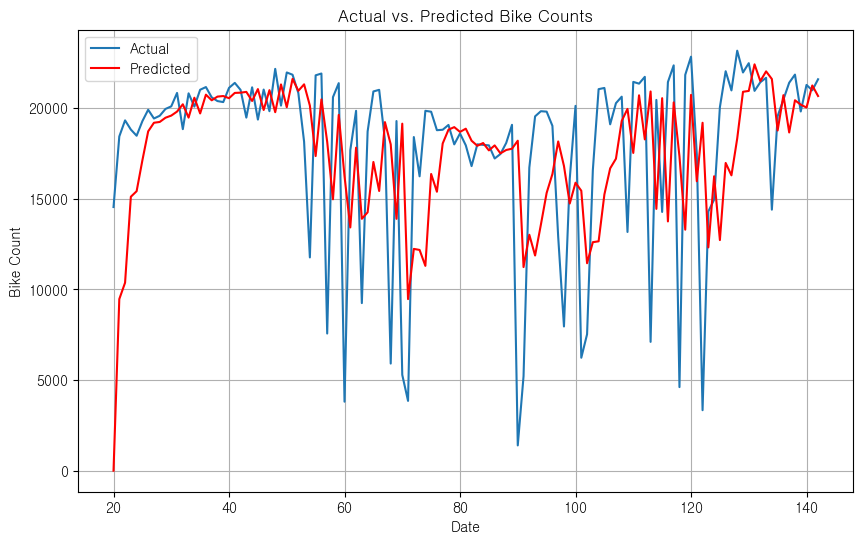

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# 데이터 전처리
기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])

# ARIMA 모델을 학습하기 위한 시계열 데이터 준비
시계열_데이터 = 기상청_분석_01['전체_건수']

# ARIMA 모델 학습
model = ARIMA(시계열_데이터, order=(5,1,0)) # ARIMA 모델 생성
model_fit = model.fit() # 모델 학습

# 예측 결과 출력
print(model_fit.summary())

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(시계열_데이터.index, 시계열_데이터.values, label='Actual')
plt.plot(시계열_데이터.index, model_fit.predict(start=0, end=len(시계열_데이터)-1), label='Predicted', color='red')
plt.title('Actual vs. Predicted Bike Counts')
plt.xlabel('Date')
plt.ylabel('Bike Count')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
기상청_분석_01

,강수량,전체_건수
기준_날짜,,
2023-05-01,0.0,14548
2023-05-02,0.0,18444
2023-05-03,0.0,19330
2023-05-04,0.0,18824
2023-05-08,0.0,18482
...,...,...
2023-10-25,0.0,21856
2023-10-26,0.0,19820
2023-10-27,0.0,21286


C:\Users\ciw96\AppData\Local\Temp\ipykernel_53944\2577600771.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])  # 기준_날짜를 datetime 형식으로 변환


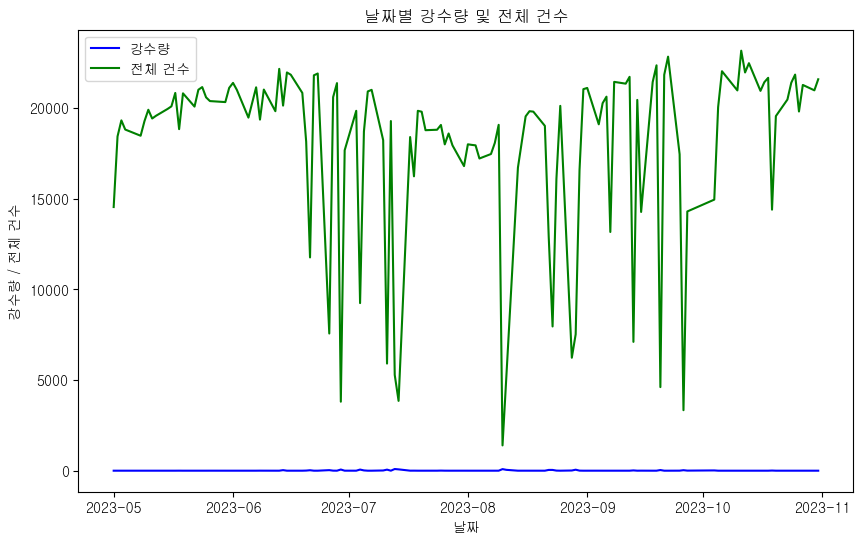

In [140]:
import pandas as pd
import matplotlib.pyplot as plt



기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])  # 기준_날짜를 datetime 형식으로 변환


# 시각화
plt.figure(figsize=(10, 6))
plt.plot(기상청_분석_01.index, 기상청_분석_01['강수량'], label='강수량', color='blue')
plt.plot(기상청_분석_01.index, 기상청_분석_01['전체_건수'], label='전체 건수', color='green')
plt.xlabel('날짜')
plt.ylabel('강수량 / 전체 건수')
plt.title('날짜별 강수량 및 전체 건수')
plt.legend()
plt.show()

In [142]:
import pandas as pd
import matplotlib.pyplot as plt


# '기준_날짜'를 날짜형식으로 변환
기상청_분석_01['기준_날짜'] = pd.to_datetime(기상청_분석_01['기준_날짜'])

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(기상청_분석_01['기준_날짜'], 기상청_분석_01['강수량'], label='강수량', color='blue')
plt.plot(기상청_분석_01['기준_날짜'], 기상청_분석_01['전체_건수'], label='전체 건수', color='green')
plt.xlabel('날짜')
plt.ylabel('강수량 / 전체 건수')
plt.title('날짜별 강수량 및 전체 건수')
plt.legend()
plt.show()

KeyError: '기준_날짜'